##### L’exercice proposé ci-dessous est basé sur un problème de recalage de modèle à partir de mesures de rigidités transversales pour des enveloppes poids lourd. Les données sont mises à disposition dans les fichiers « 315 80 R 22.5.txt, 385 55 R 22.5.txt, 495 45 R 22.5.txt » avec 3 colonnes : 
- Charge (noté $Fz$) en Newton,
- Pression (noté $P$) en Bar,
- Rigidité (noté $Dz$) en N/°. 

Les coefficients à optimiser sont notés $a1, a2, a3, a4$ et $a5$. Le modèle à ajuster est le suivant :

$\displaystyle Dz = (a1 \times P + a2) \times \sin \left(a3 \times \arctan{\left(\frac{Fz}{a4 \times P + a5}\right)} \right)$

Cet exercice est séparé en dex parties. La première consiste à résoudre le problème d'identification de paramètres en utilisant des outils classiques d'optimisation. La seconde vise à trouver les solutions via une approche d'optimisation bayesienne.

## Identification par Optimisation Classique

### Chargement des Données

Veuillez tout d'abord charger les mesures de rigidités de dérive contenues dans le fichier " 315 80 R 22.5.txt".

In [1]:
import numpy as np
import scipy as sp
from scipy import linalg as LA
from scipy.optimize import leastsq as LB
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

chemin = "315 80 R 22.5.txt"
mat = np.loadtxt(chemin)
Fz = mat[:, 0] # N
P  = mat[:, 1] # Bar
Dz = mat[:, 2] # N/°

Ces mesures correspondents à des valeurs de rigidités de dérive pour trois niveaux de pression 7, 8.5 et 9.5 bars. Chaque palier de pression comporte 7 points de mesure.
Afficher les mesures $Dz(Fz)$ pour chaque palier de pression

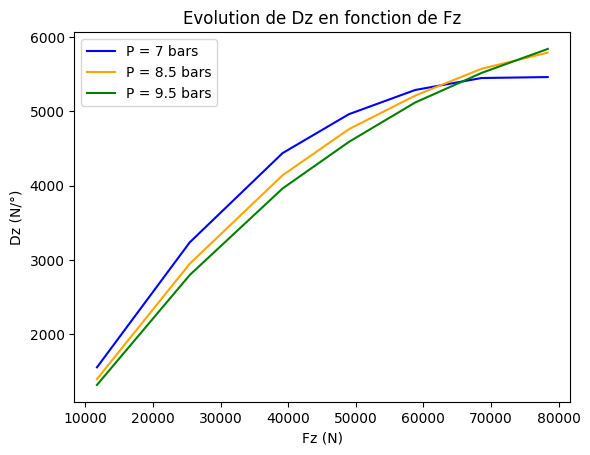

In [2]:
# Affichage des Mesures

plt.plot(Fz[:7], Dz[:7], label="P = 7 bars", color="blue")
plt.plot(Fz[7:14], Dz[7:14], label="P = 8.5 bars", color="orange")
plt.plot(Fz[14:], Dz[14:], label="P = 9.5 bars", color="green")
plt.xlabel('Fz (N)')
plt.ylabel('Dz (N/°)')
plt.legend()
plt.title("Evolution de Dz en fonction de Fz")
plt.show()

### Estimation des Valeurs Initiales

L’exercice est un problème d’optimisation continue, non linéaire et sans contrainte. Il est donc nécessaire d'initialiser les paramètres afin de pouvoir lancer un algorithme d'optimisation type recherche linéaire ou région de confiance.

Comment, à votre avis, peut-on essayer d’estimer les coefficients du modèle à partir des mesures ? Pour vous aider, n’oubliez pas que la fonction sinus est bornée. De plus, cadeau, je vous conseille d’approcher a3 par la valeur 2. Il vous reste seulement 4 petits coef à trouver…

Second conseil, le modèle peut également s’écrire sous la forme suivante, idéale quand on connaît déjà $a1, a2$ et $a3$, avec quelques restrictions cependant sur le domaine de définition des fonctions $1/x$, $\arctan$ et $\arcsin$:

$\displaystyle a4 \times P + a5 = \frac{Fz}{\tan \left(\frac{1}{a3} \times \arcsin\left(\frac{Dz}{a1 \times P + a2} \right) \right)}$

<div style="color: blue; font-weight: bold; font-size: 18px;">
    Estimation des paramètres $a1$ et $a2$
</div>

<div style="color: blue;">
    Pour estimer les paramètres $a1$ et $a2$, on peut réécrire la formule initiale comme ceci :
    <br>
    $$a1 \times P + a2 = \frac{\displaystyle Dz}{\sin \left(a3 \times \arctan{\left(\frac{Fz}{a4 \times P + a5}\right)} \right)}$$
    <br>
    En considérant le fait que la fonction sinus est bornée entre $-1$ et $1$, on a donc :
    <br>
    \[
    \left \{
    \begin{array}{c @{=} c}
        a1 \times P + a2 = Dz_{max} \\
        a1 \times P + a2 = - Dz_{min}
    \end{array}
    \right.
    \]
    <br>
    Cela signifie que $a1 \times P + a2$ représente l'amplitude de $Dz$, on va donc prendre la première relation avec les $3$ valeurs de pression afin d'utiliser l'amplitude maximale :
    <br>
    \[
    \left \{
    \begin{array}{c @{=} c}
        a1 \times P_7 + a2 = \max_{P=7} Dz \\
        a1 \times P_{8.5} + a2 = \max_{P=8.5} Dz \\
        a1 \times P_{9.5} + a2 = \max_{P=9.5} Dz
    \end{array}
    \right.
    \]
    <br>
    Ce qui peut se réécrire sous la forme matricielle suivante : $Ax = y$ :
    \[
    \begin{pmatrix}
        P_7     & 1 \\
        P_{8.5} & 1 \\
        P_{9.5} & 1
    \end{pmatrix}
    \begin{pmatrix}
        a1 \\
        a2
    \end{pmatrix}
    =
    \begin{pmatrix}
        \max_{P=7} Dz \\
        \max_{P=8.5} Dz \\
        \max_{P=9.5} Dz
    \end{pmatrix}
    \]
    <br>
    Pour résoudre ce système et trouver le vecteur $x$ et donc les valeurs $a1$ et $a2$, on va utiliser la méthode des moindres carrées
</div>

In [3]:
# Vecteur des différentes pressions
P_leastsq = np.array([7, 8.5, 9.5])

# Vecteur des valeurs maximales de Dz pour chaque valeur de pression
y_leastsq = np.array([np.max(Dz[:7]), np.max(Dz[7:14]), np.max(Dz[14:])])

# Construction de la matrice du système
A_leastsq = np.column_stack((P_leastsq, np.ones_like(P_leastsq)))

# Equation du système matricielle
def equation_matricielle(x, A, y):
    return np.dot(A, x) - y

# Initialisation du vecteur x0 pour qui va contenir les estimations
x0 = np.zeros(A_leastsq.shape[1])

# Utilisation de leastsq pour trouver x
x, _, infodict, _, is_solution_found = LB(
    equation_matricielle, x0, args=(A_leastsq, y_leastsq), full_output=True
)

a1_leastsq = x[0]
a2_leastsq = x[1]

if is_solution_found in [1, 2, 3, 4]:
    print("La solution a été trouvée :")
    print(f"Nombre d'appels de la fonction : {infodict['nfev']}")
    print(f"a1 = {a1_leastsq}")
    print(f"a2 = {a2_leastsq}")
else:
    print("La solution n'a pas été trouvée, voici les résultats de la dernière itération :")
    print(f"Nombre d'appels de la fonction : {infodict['nfev']}")
    print(f"a1 = {a1_leastsq}")
    print(f"a2 = {a2_leastsq}")

La solution a été trouvée :
Nombre d'appels de la fonction : 25
a1 = 156.72789962885517
a2 = 4390.194169759539


<div style="color: blue; font-weight: bold; font-size: 18px;">
    Estimation des paramètres $a4$ et $a5$
</div>

<div style="color: blue;">
    Pour estimer les paramètres $a4$ et $a5$, on part de cette formule :
    $$\displaystyle a4 \times P + a5 = \frac{Fz}{\tan \left(\frac{1}{a3} \times \arcsin\left(\frac{Dz}{a1 \times P + a2} \right) \right)}$$
    <br>
    On peut donc écrire l'équation suivante pour chaque valeur de pression en posant $T_P = \frac{Fz}{\tan \left(\frac{1}{a3} \times \arcsin\left(\frac{Dz}{a1 \times P + a2} \right) \right)}$:
    <br>
    $$a4 \times P + a5 = T_P$$
    <br>
    On va donc construire un système qui va contenir cette équation pour chaque valeur de pression et pour chaque valeur de $T_P$, ce système aura donc $7$ lignes par valeur de pression, soit $21$ lignes au total :
    <br>
    \[
    \left \{
    \begin{array}{c @{=} c}
        a4 \times P_7 + a5 = T_{P=7}[0] \\
        ... \\
        a4 \times P_7 + a5 = T_{P=7}[6] \\
        a4 \times P_{8.5} + a5 = T_{P=8.5}[0] \\
        ... \\
        a4 \times P_{8.5} + a5 = T_{P=8.5}[6] \\
        a4 \times P_{9.5} + a5 = T_{P=9.5}[0] \\
        ... \\
        a4 \times P_{9.5} + a5 = T_{P=9.5}[6] \\
    \end{array}
    \right.
    \]
    <br>
    <br>
    Ce qui peut se réécrire sous la forme matricielle suivante : $Ax = y$
    \[
    \begin{pmatrix}
        P_7     & 1 \\
        ... \\
        P_7     & 1 \\
        P_{8.5} & 1 \\
        ... \\
        P_{8.5} & 1 \\
        P_{9.5} & 1 \\
        ... \\
        P_{9.5} & 1
    \end{pmatrix}
    \begin{pmatrix}
        a4 \\
        a5
    \end{pmatrix}
    =
    \begin{pmatrix}
        T_{P=7}[0] \\
        ... \\
        T_{P=7}[6] \\
        T_{P=8.5}[0] \\
        .. \\
        T_{P=8.5}[6] \\
        T_{P=9.5}[0] \\
        ... \\
        T_{P=9.5}[6] \\
    \end{pmatrix}
    \]
    <br>
    Pour résoudre ce système et trouver le vecteur $x$ et donc les valeurs de $a4$ et $a5$, on va utiliser la méthode des moindres carrées. Cependant il faudra faire attention à enlever les lignes pour lesquelles $\frac{Dz}{a1 \times P + a2} > 1$. En effet, pour ces valeurs, la fonction $arcsin$ n'est pas définie et cela va poser un problème
</div>

In [4]:
# Définition du calcul des éléments du vecteur y
def Tp(Fz, Dz, P, a1, a2):
    return Fz / np.tan(1/2 * np.arcsin(Dz / (a1 * P + a2)))

In [5]:
# Vecteur des différentes pressions
P_leastsq = P

# Vecteur des valeurs de Tp pour chaque valeur de pression
y_leastsq = np.concat([
    Tp(Fz[:7], Dz[:7], 7, a1_leastsq, a2_leastsq),
    Tp(Fz[7:14], Dz[7:14], 8.5, a1_leastsq, a2_leastsq),
    Tp(Fz[14:], Dz[14:], 9.5, a1_leastsq, a2_leastsq)
])

# On va supprimer les valeurs aux indices pour lesquelles la valeur de l'arcsin n'est pas définie
ind = np.where(np.isnan(y_leastsq))
for elt in ind:
    P_leastsq = np.delete(P_leastsq, elt[0])
    y_leastsq = np.delete(y_leastsq, elt[0])

# Construction de la matrice du système
A_leastsq = np.column_stack((P_leastsq, np.ones_like(P_leastsq)))

# Equation du système matricielle
def equation_matricielle(x, A, y):
    return np.dot(A, x) - y

# Initialisation du vecteur x0 pour qui va contenir les estimations
x0 = np.zeros(A_leastsq.shape[1])

# Utilisation de leastsq pour trouver x
x, _, infodict, _, is_solution_found = LB(
    equation_matricielle, x0, args=(A_leastsq, y_leastsq), full_output=True
)

a4_leastsq = x[0]
a5_leastsq = x[1]

if is_solution_found in [1, 2, 3, 4]:
    print("La solution a été trouvée :")
    print(f"Nombre d'appels de la fonction : {infodict['nfev']}")
    print(f"a4 = {a4_leastsq}")
    print(f"a5 = {a5_leastsq}")
else:
    print("La solution n'a pas été trouvée, voici les résultats de la dernière itération :")
    print(f"Nombre d'appels de la fonction : {infodict['nfev']}")
    print(f"a4 = {a4_leastsq}")
    print(f"a5 = {a5_leastsq}")

La solution a été trouvée :
Nombre d'appels de la fonction : 40
a4 = 8061.175012628266
a5 = 22848.06726020738


<div style="color: blue; font-weight: bold; font-size: 18px;">
    Récapitulatif des valeurs trouvées pour les paramètres recherchés
</div>

In [6]:
# Estimation initiale de a1 et a2
a1_opt_leastsq = a1_leastsq
a2_opt_leastsq = a2_leastsq

# Pour a3, on l'approche par la valeur 2
a3_opt_leastsq = 2

# Estimation initiale de a4 et a5    
a4_opt_leastsq = a4_leastsq
a5_opt_leastsq = a5_leastsq

print("Valeurs trouvées avec la méthode des moindres carrés")
print(f"a1 = {a1_opt_leastsq}")
print(f"a2 = {a2_opt_leastsq}")
print(f"a3 = {a3_opt_leastsq}")
print(f"a4 = {a4_opt_leastsq}")
print(f"a5 = {a5_opt_leastsq}")

Valeurs trouvées avec la méthode des moindres carrés
a1 = 156.72789962885517
a2 = 4390.194169759539
a3 = 2
a4 = 8061.175012628266
a5 = 22848.06726020738


Superposer les courbes de mesures et de prédictions obtenues avec l'initialisation trouvée. Que constatez-vous?

In [7]:
# Fonction permettant de simuler le modèle
# Entrées: paramètres du modèle
# Return: la valeur de Dz

def model(a1, a2, a3, a4, a5, P, Fz):
    return (a1 * P + a2) * np.sin(a3 * np.arctan(Fz / (a4 * P + a5)))

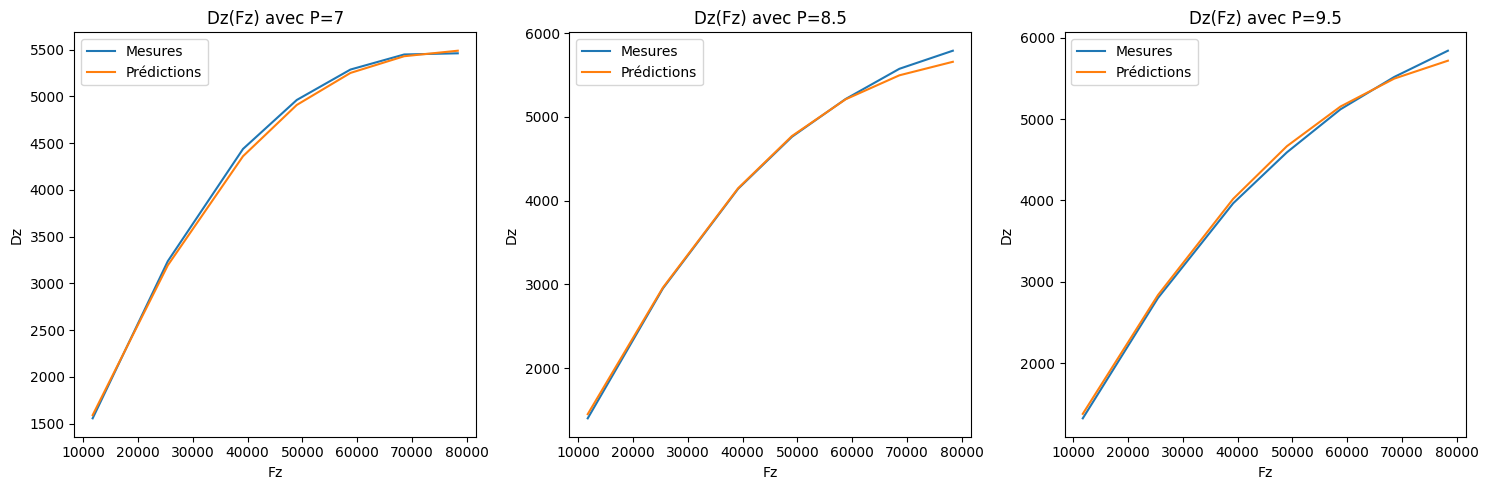

In [8]:
# Affichage de la superposition mesures/prédictions

fig, axes = plt.subplots(1, 3, figsize=(15, 5)) # 1 ligne avec 3 plots

# P = 7
pred_7_leastsq = [model(a1_opt_leastsq, a2_opt_leastsq, a3_opt_leastsq, a4_opt_leastsq, a5_opt_leastsq, P[:7][i], Fz[:7][i]) for i in range(len(Fz[:7]))]
axes[0].plot(Fz[:7], Dz[:7], label="Mesures")
axes[0].plot(Fz[:7], pred_7_leastsq, label="Prédictions")
axes[0].set_xlabel('Fz')
axes[0].set_ylabel('Dz')
axes[0].legend()
axes[0].set_title("Dz(Fz) avec P=7")

# P = 8.5
pred_8_5_leastsq = [model(a1_opt_leastsq, a2_opt_leastsq, a3_opt_leastsq, a4_opt_leastsq, a5_opt_leastsq, P[7:14][i], Fz[7:14][i]) for i in range(len(Fz[7:14]))]
axes[1].plot(Fz[7:14], Dz[7:14], label="Mesures")
axes[1].plot(Fz[7:14], pred_8_5_leastsq, label="Prédictions")
axes[1].set_xlabel('Fz')
axes[1].set_ylabel('Dz')
axes[1].legend()
axes[1].set_title("Dz(Fz) avec P=8.5")

# P = 9.5
pred_9_5_leastsq = [model(a1_opt_leastsq, a2_opt_leastsq, a3_opt_leastsq, a4_opt_leastsq, a5_opt_leastsq, P[14:][i], Fz[14:][i]) for i in range(len(Fz[14:]))]
axes[2].plot(Fz[14:], Dz[14:], label="Mesures")
axes[2].plot(Fz[14:], pred_9_5_leastsq, label="Prédictions")
axes[2].set_xlabel('Fz')
axes[2].set_ylabel('Dz')
axes[2].legend()
axes[2].set_title("Dz(Fz) avec P=9.5")

plt.tight_layout()
plt.show()

<div style="color: blue;">
    On peut remarquer que l'on arrive à approcher de façon très correcte les courbes de mesures
</div>

### Fine Tuning des valeurs

Dans le but d'affiner les valeurs obtenues à l'issue de la phase d'initialisation, il est nécessaire de faire appel à un algorithme d'optimisation non linéaire.

En l'occurence, il s'agit d'un problème de curve fitting. 

Quel critère est-il pertinent de considérer? 

Quel type d'algorithme peut-on mettre en oeuvre? 

Implémenter l'optimisation des valeurs des coefficients.

<div style="color: blue;">
    On va cherhcer à minimiser l'erreur quadratique moyenne (Mean Square Error, MSE)
    <br>
    On va utiliser 2 algorithmes différents :
    <ol>
        <li>Descente de gradient : on calcule les gradients (dérivées partielles) de la fonction de coût par rapport aux paramètres et on les ajuste pour minimiser la fonction</li>
        <li>BFGS (Broyden-Fletcher-Goldfarb-Shanno) ou méthode quasi-Newton : ici, les approximations itératives se font avec la matrice Hessienne (dérivées secondes)</li>
    </ol>
</div>

<div style="color: blue; font-weight: bold; font-size: 18px;">
    Première approche avec la descente de gradient
</div>

<div style="color: blue;">
    <br>
    On fait bien attention à ne pas modifier la valeur de $a3$
</div>

In [9]:
# Fonction permettant de calculer la fonction coût
# Entrées: paramètres à optimiser
# Return: la valeur du critère à optimiser

def cost_function(a1, a2, a3, a4, a5, P, Fz, Dz):
    predictions = model(a1, a2, a3, a4, a5, P, Fz)
    return 0.5 * np.mean(Dz - predictions) ** 2

<div style="background-color: #FFF9C4; border-left: 6px solid #FFEB3B; padding: 10px; color: #795548; font-weight: bold; font-size: 16px;">
💡 Astuce : Pour dériver $Dz$ par rapport à $a4$ et $a5$, il faut utiliser la dérivée composée de fonctions : $(g\circ f)'=(g'\circ f)\cdot f'$
</div>

$ \frac{\partial Dz}{\partial a1} = P \times \sin \left(a3 \times \arctan\left(\frac{Fz}{a4 \times P + a5}\right) \right) $

$ \frac{\partial Dz}{\partial a2} = \sin \left(a3 \times \arctan\left(\frac{Fz}{a4 \times P + a5}\right) \right) $

$ \frac{\partial Dz}{\partial a3} = \left(a1 \times P + a2\right) \times \arctan\left(\frac{Fz}{a4 \times P + a5} \right) \times \cos \left(a3 \times \arctan\left(\frac{Fz}{a4 \times P + a5}\right) \right) $

$ \frac{\partial Dz}{\partial a4} = P \times \frac{-Fz \times a3 \times \left(a1 \times P + a2\right) \times \cos\left(a3 \times \arctan\left(\frac{Fz}{a4 \times P + a5} \right) \right)}{\left(a4 \times P + a5\right)^2 + Fz^2} $

$ \frac{\partial Dz}{\partial a5} = \frac{-Fz \times a3 \times \left(a1 \times P + a2\right) \times \cos\left(a3 \times \arctan\left(\frac{Fz}{a4 \times P + a5} \right) \right)}{\left(a4 \times P + a5\right)^2 + Fz^2} $

Valeurs trouvées avec la descente de gradient :
a1 = 155.68254480079815
a2 = 4470.06303254187
a3 = 2
a4 = 8281.767469981256
a5 = 22862.311527055972


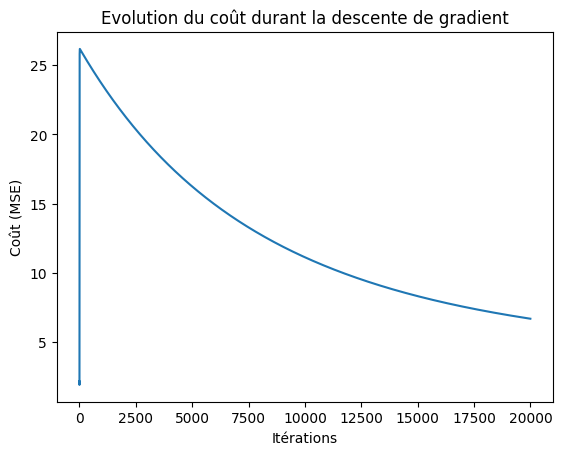

In [10]:
# Optimisation des paramètres

def compute_gradients(a1, a2, a3, a4, a5, P, Fz, Dz):
    predictions = model(a1, a2, a3, a4, a5, P, Fz)
    
    # Calculs temporaires pour plus de visibilite
    arctan_term = np.arctan(Fz / (a4 * P + a5))
    sin_term = np.sin(a3 * arctan_term)
    cos_term = np.cos(a3 * arctan_term)

    # Derivees par rapport a a1, a2, a4, a5
    df_a2 = sin_term
    df_a1 = P * df_a2
    
    df_a5 = (- Fz * a3 * (a1 * P + a2) * cos_term) / ((a4 * P + a5)**2 + Fz**2)
    df_a4 = P * df_a5
    
    # Gradients par rapport a a1, a2, a4, a5
    grad_a1 = np.mean((predictions - Dz) * df_a1)
    grad_a2 = np.mean((predictions - Dz) * df_a2)
    grad_a4 = np.mean((predictions - Dz) * df_a4)
    grad_a5 = np.mean((predictions - Dz) * df_a5)
    
    return grad_a1, grad_a2, grad_a4, grad_a5

def gradient_descent(a1_init, a2_init, a3_init, a4_init, a5_init, P, Fz, Dz, learning_rate, num_iterations):
    a1, a2, a3, a4, a5 = a1_init, a2_init, a3_init, a4_init, a5_init
    cost_history = []
    
    for i in range(num_iterations):
        grad_a1, grad_a2, grad_a4, grad_a5 = compute_gradients(a1, a2, a3, a4, a5, P, Fz, Dz)
        
        # Mise à jour des coefficients
        a1 -= learning_rate * grad_a1
        a2 -= learning_rate * grad_a2
        a4 -= learning_rate * grad_a4
        a5 -= learning_rate * grad_a5
        
        # Calcul du coût et enregistrement de l'historique
        cost = cost_function(a1, a2, a3, a4, a5, P, Fz, Dz)
        cost_history.append(cost)
        
        #if i % 1000 == 0:
        #    print(f"Iteration {i}: Cost = {cost}")
    
    return a1, a2, a3, a4, a5, cost_history

a1_init = a1_opt_leastsq
a2_init = a2_opt_leastsq
a3_init = a3_opt_leastsq
a4_init = a4_opt_leastsq
a5_init = a5_opt_leastsq
learning_rate = 0.01
num_iterations = 20000

a1_opt_gradient, a2_opt_gradient, a3_opt_gradient, a4_opt_gradient, a5_opt_gradient, cost_history = gradient_descent(
    a1_init, a2_init, a3_init, a4_init, a5_init, P, Fz, Dz, learning_rate, num_iterations
)

# Affichage des résultats
print("Valeurs trouvées avec la descente de gradient :")
print(f"a1 = {a1_opt_gradient}")
print(f"a2 = {a2_opt_gradient}")
print(f"a3 = {a3_opt_gradient}")
print(f"a4 = {a4_opt_gradient}")
print(f"a5 = {a5_opt_gradient}")

# Affichage de l'evolution du coût
plt.plot(cost_history)
plt.xlabel('Itérations')
plt.ylabel('Coût (MSE)')
plt.title('Evolution du coût durant la descente de gradient')
plt.show()

<div style="color: blue; font-weight: bold; font-size: 18px;">
    Comparaison des courbes avec la descente de gradients
</div>

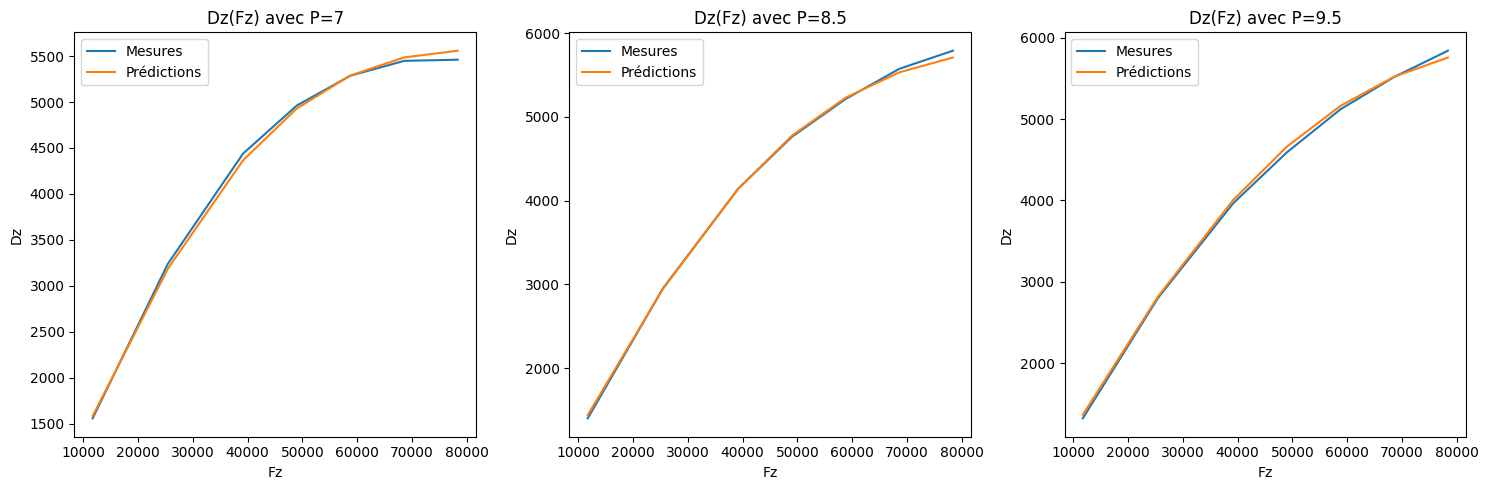

In [11]:
# Affichage de la superposition mesures/prédictions avec les nouvelles valeurs optimisées des paramètres

fig, axes = plt.subplots(1, 3, figsize=(15, 5)) # 1 ligne avec 3 plots

pred_7_gradient = [model(a1_opt_gradient, a2_opt_gradient, a3_opt_gradient, a4_opt_gradient, a5_opt_gradient, P[:7][i], Fz[:7][i]) for i in range(len(Fz[:7]))]
axes[0].plot(Fz[:7], Dz[:7], label="Mesures")
axes[0].plot(Fz[:7], pred_7_gradient, label="Prédictions")
axes[0].set_xlabel('Fz')
axes[0].set_ylabel('Dz')
axes[0].legend()
axes[0].set_title("Dz(Fz) avec P=7")

pred_8_5_gradient = [model(a1_opt_gradient, a2_opt_gradient, a3_opt_gradient, a4_opt_gradient, a5_opt_gradient, P[7:14][i], Fz[7:14][i]) for i in range(len(Fz[7:14]))]
axes[1].plot(Fz[7:14], Dz[7:14], label="Mesures")
axes[1].plot(Fz[7:14], pred_8_5_gradient, label="Prédictions")
axes[1].set_xlabel('Fz')
axes[1].set_ylabel('Dz')
axes[1].legend()
axes[1].set_title("Dz(Fz) avec P=8.5")

pred_9_5_gradient = [model(a1_opt_gradient, a2_opt_gradient, a3_opt_gradient, a4_opt_gradient, a5_opt_gradient, P[14:][i], Fz[14:][i]) for i in range(len(Fz[14:]))]
axes[2].plot(Fz[14:], Dz[14:], label="Mesures")
axes[2].plot(Fz[14:], pred_9_5_gradient, label="Prédictions")
axes[2].set_xlabel('Fz')
axes[2].set_ylabel('Dz')
axes[2].legend()
axes[2].set_title("Dz(Fz) avec P=9.5")

plt.tight_layout()
plt.show()

<div style="color: blue; font-weight: bold; font-size: 18px;">
    Deuxième approche avec la méthode quasi-Newton en utilisant la fonction minimize de scipy
</div>

In [12]:
# Définition de la fonction pour calculer le modèle
def calculate_model(params, P, Fz):
    a1, a2, a3, a4, a5 = params
    return (a1 * P + a2) * np.sin(a3 * np.arctan(Fz / (a4 * P + a5)))

# Fonction objectif à minimiser
def fonction_objectif(params, P, Fz, Dz_cible):
    Dz_pred = calculate_model(params, P, Fz)
    return 0.5 * np.sum((Dz_pred - Dz_cible)**2)

# Initialisation des paramètres
params_init = [a1_opt_leastsq, a2_opt_leastsq, a3_opt_leastsq, a4_opt_leastsq, a5_opt_leastsq]

# Appel de l'optimiseur
result = minimize(fonction_objectif, params_init, args=(P, Fz, Dz))

a1_opt_minimize = result.x[0]
a2_opt_minimize = result.x[1]
a3_opt_minimize = 2
a4_opt_minimize = result.x[3]
a5_opt_minimize = result.x[4]

# Résultats
print("Valeurs trouvées avec minimize :")
print(f"a1 = {a1_opt_minimize}")
print(f"a2 = {a2_opt_minimize}")
print(f"a3 = {a3_opt_minimize}")
print(f"a4 = {a4_opt_minimize}")
print(f"a5 = {a5_opt_minimize}")

Valeurs trouvées avec minimize :
a1 = 240.79118977160465
a2 = 3796.500922864919
a3 = 2
a4 = 12075.21690529986
a5 = -3844.141926687247


Superposer les courbes de mesures et de prédictions obtenues avec les valeurs finales trouvées. A-t-on améliorer la qualité de prédiction du modèle par rapport à la phase d'initialisation? Comment peut-on le quantifier?

<div style="color: blue; font-weight: bold; font-size: 18px;">
    Comparaison des courbes avec la méthode quasi-Newton
</div>

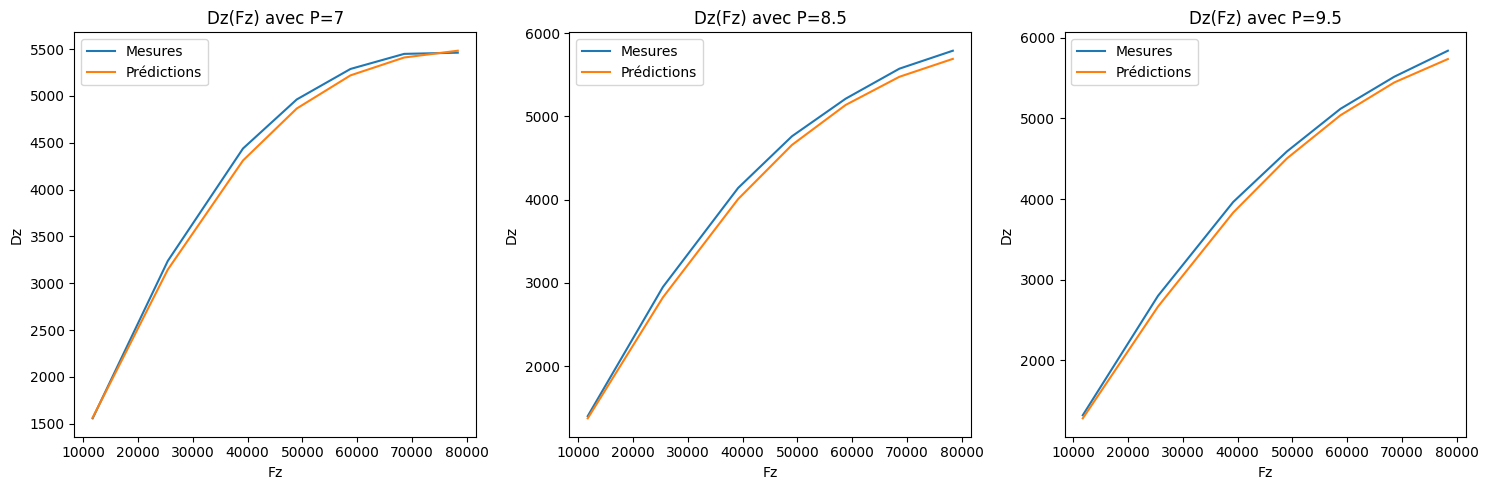

In [13]:
# Affichage de la superposition mesures/prédictions avec les nouvelles valeurs optimisées des paramètres

fig, axes = plt.subplots(1, 3, figsize=(15, 5)) # 1 ligne avec 3 plots

pred_7_minimize = [model(a1_opt_minimize, a2_opt_minimize, a3_opt_minimize, a4_opt_minimize, a5_opt_minimize, P[:7][i], Fz[:7][i]) for i in range(len(Fz[:7]))]
axes[0].plot(Fz[:7], Dz[:7], label="Mesures")
axes[0].plot(Fz[:7], pred_7_minimize, label="Prédictions")
axes[0].set_xlabel('Fz')
axes[0].set_ylabel('Dz')
axes[0].legend()
axes[0].set_title("Dz(Fz) avec P=7")

pred_8_5_minimize = [model(a1_opt_minimize, a2_opt_minimize, a3_opt_minimize, a4_opt_minimize, a5_opt_minimize, P[7:14][i], Fz[7:14][i]) for i in range(len(Fz[7:14]))]
axes[1].plot(Fz[7:14], Dz[7:14], label="Mesures")
axes[1].plot(Fz[7:14], pred_8_5_minimize, label="Prédictions")
axes[1].set_xlabel('Fz')
axes[1].set_ylabel('Dz')
axes[1].legend()
axes[1].set_title("Dz(Fz) avec P=8.5")

pred_9_5_minimize = [model(a1_opt_minimize, a2_opt_minimize, a3_opt_minimize, a4_opt_minimize, a5_opt_minimize, P[14:][i], Fz[14:][i]) for i in range(len(Fz[14:]))]
axes[2].plot(Fz[14:], Dz[14:], label="Mesures")
axes[2].plot(Fz[14:], pred_9_5_minimize, label="Prédictions")
axes[2].set_xlabel('Fz')
axes[2].set_ylabel('Dz')
axes[2].legend()
axes[2].set_title("Dz(Fz) avec P=9.5")

plt.tight_layout()
plt.show()

<div style="color: blue; font-weight: bold; font-size: 18px;">
    Interprétation des résultats avec les 2 méthodes
</div>

<div style="color: blue;">
    <br>
    D'après les graphiques, on voit que la descente de gradient est beaucoup plus efficace que la méthode quasi-Newton
</div>

## Identification par Optimisation Bayesienne

Comme précisé plus haut, cette partie vise à résoudre le problème d'identification via une approche bayesienne. Pour ce faire, nous allons nous appuyer sur le package python scikit-optimize (https://scikit-optimize.github.io/stable/).

In [14]:
from skopt import gp_minimize
from skopt.plots import plot_gaussian_process, plot_convergence
from skopt.space import Real
from skopt.sampler import Lhs

### Premier Essai

Nous travaillons toujours avec la même fonction objectif utilisée dans la première partie du TP. On va considérer de plus les bornes suivantes:
- $200 \leq a1 \leq 300$
- $3000 \leq a2 \leq 4500$
- $1 \leq a3 \leq 3$
- $1e4 \leq a4 \leq 2e4$
- $-5e3 \leq a5 \leq -2e3$

La fonction d'acquisition qui sera utilisée dans un premier temps est l'amélioration espérée (Expected Improvement). Nous fixerons le nombre d'appels à la fonction coût originale à 100. Enfin, on utilise un plan de type LHS avec 50 points pour construire le modèle de krigeage avant la permière minimisation de la fonction d'acquisition.

A l'aide de la documentation du package scikit-optimize, implémenter cette première tentative d'optimisation bayesienne et visualiser le graphe de convergence. A-t-on le même niveau de convergence qu'observé dans la première section du TP? Comment pourrait-on améliorer la convergence?

In [15]:
# Fonction permettant de calculer la fonction coût au format attendu par scikit-optimize
# Entrées: paramètres à optimiser
# Return: la valeur du critère à optimiser 

def cost_function_bayesian(params): # params est obligatoire pour scikit-optimize
    a1, a2, a3, a4, a5 = params
    predictions = model(a1, a2, a3, a4, a5, P, Fz)
    return 0.5 * np.mean(Dz - predictions) ** 2

In [16]:
# Définition des bornes

dimensions = [
    Real(200, 300, name='a1'),
    Real(3000, 4500, name='a2'),
    Real(1, 3, name='a3'),
    Real(1e4, 2e4, name='a4'),
    Real(-5e3, -2e3, name='a5')
]

In [17]:
# Définition des options du LHS

lhs_type = "classic"
criterion = "maximin"

In [18]:
# Effectuer l'optimisation

random_seed = 2024

# Création du plan LHS avec 50 points
lhs = Lhs(lhs_type=lhs_type, criterion=criterion)
lhs_samples = lhs.generate(n_samples=50, dimensions=dimensions, random_state=random_seed)

result = gp_minimize(
    func=cost_function_bayesian, # Fonction objectif
    dimensions=dimensions, # Espace de recherche
    n_calls=100, # Nombre d'appels à la fonction objectif
    acq_func="EI", # Fonction d'acquisition (Expected Improvement)
    x0=lhs_samples,
    random_state=random_seed
)

In [19]:
# Estimation des paramètres par optimisation bayesienne
a1_opt_bayes = result.x[0]
a2_opt_bayes = result.x[1]
a3_opt_bayes = 2
a4_opt_bayes = result.x[3]
a5_opt_bayes = result.x[4]

print(f"Best score = {result.fun}")
print()
print(f"Valeurs trouvées :")
print(f"a1 = {a1_opt_bayes}")
print(f"a2 = {a2_opt_bayes}")
print(f"a3 = {a3_opt_bayes}")
print(f"a4 = {a4_opt_bayes}")
print(f"a5 = {a5_opt_bayes}")

Best score = 1.0053367335403656

Valeurs trouvées :
a1 = 246.3055849805997
a2 = 3539.0568868274686
a3 = 2
a4 = 10000.0
a5 = -2000.0


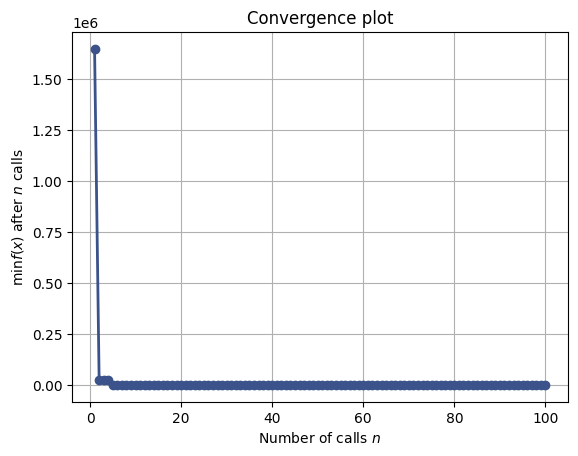

In [20]:
# Affichage de l'évolution de la fonction coût au fil des itérations via la fonction "plot_convergence" de scikit-optimize

plot_convergence(result)
plt.show()

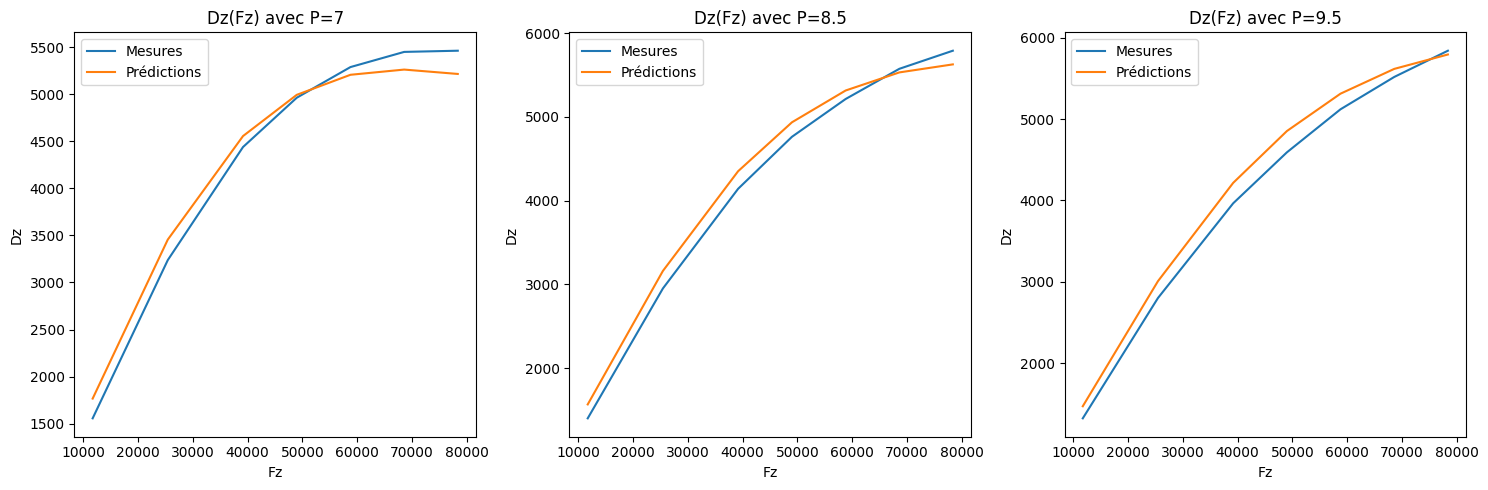

In [21]:
# Affichage de la superposition mesures/prédictions avec les nouvelles valeurs optimisées des paramètres

fig, axes = plt.subplots(1, 3, figsize=(15, 5)) # 1 ligne avec 3 plots

pred_7_bayes = [model(a1_opt_bayes, a2_opt_bayes, a3_opt_bayes, a4_opt_bayes, a5_opt_bayes, P[:7][i], Fz[:7][i]) for i in range(len(Fz[:7]))]
axes[0].plot(Fz[:7], Dz[:7], label="Mesures")
axes[0].plot(Fz[:7], pred_7_bayes, label="Prédictions")
axes[0].set_xlabel('Fz')
axes[0].set_ylabel('Dz')
axes[0].legend()
axes[0].set_title("Dz(Fz) avec P=7")

pred_8_5_bayes = [model(a1_opt_bayes, a2_opt_bayes, a3_opt_bayes, a4_opt_bayes, a5_opt_bayes, P[7:14][i], Fz[7:14][i]) for i in range(len(Fz[7:14]))]
axes[1].plot(Fz[7:14], Dz[7:14], label="Mesures")
axes[1].plot(Fz[7:14], pred_8_5_bayes, label="Prédictions")
axes[1].set_xlabel('Fz')
axes[1].set_ylabel('Dz')
axes[1].legend()
axes[1].set_title("Dz(Fz) avec P=8.5")

pred_9_5_bayes = [model(a1_opt_bayes, a2_opt_bayes, a3_opt_bayes, a4_opt_bayes, a5_opt_bayes, P[14:][i], Fz[14:][i]) for i in range(len(Fz[14:]))]
axes[2].plot(Fz[14:], Dz[14:], label="Mesures")
axes[2].plot(Fz[14:], pred_9_5_bayes, label="Prédictions")
axes[2].set_xlabel('Fz')
axes[2].set_ylabel('Dz')
axes[2].legend()
axes[2].set_title("Dz(Fz) avec P=9.5")

plt.tight_layout()
plt.show()

<div style="color: red;">
    Impossible d'afficher le plot de la fonction d'acquisition car on est en dimension supérieure à 1
</div>

### Amélioration de la configuration de l'algorithme

Essayer différents nombres de points d'évaluation et les fonctions d'acquisition PI et LCB pour tenter d'améliorer le paramétrage de l'algorithme. A partir de l'analyse des graphiques de convergence et de fonctions d'acquisition, quelle est la configuration la plus efficiente?

In [22]:
import time

list_n_samples = [5, 10, 15, 20, 25, 30, 50]
list_n_samples = [10, 20, 30, 40, 50]
list_acq_func = ["EI", "PI", "LCB"]

grid_search_list = []
cpt = 1
nb_iter_max = len(list_n_samples) * len(list_acq_func)
nb_iter_max_format = len(str(nb_iter_max))
for n_samples in list_n_samples:
    for acq_func in list_acq_func:
        t0 = time.time()
        lhs = Lhs(lhs_type=lhs_type, criterion=criterion)
        lhs_samples = lhs.generate(n_samples=n_samples, dimensions=dimensions, random_state=random_seed)
        result = gp_minimize(
            func=cost_function_bayesian,
            dimensions=dimensions,
            n_calls=100,
            acq_func=acq_func,
            x0=lhs_samples,
            random_state=random_seed
        )
        print(f"nb_iter = {cpt:>{nb_iter_max_format}}/{nb_iter_max:>{nb_iter_max_format}} \t n_samples = {n_samples:<{5}} \t acq_func = {acq_func:<{5}} \t temps = {round(time.time() - t0, 2)}s")
        cpt += 1
        grid_search_list.append({"n_samples": n_samples, "acq_fun": acq_func, "area": np.sum(result.func_vals), "best_score": result.fun,
                                "a1": result.x[0], "a2": result.x[1], "a3": 2, "a4": result.x[3], "a5": result.x[4]})



nb_iter =  1/15 	 n_samples = 10    	 acq_func = EI    	 temps = 16.88s
nb_iter =  2/15 	 n_samples = 10    	 acq_func = PI    	 temps = 15.29s
nb_iter =  3/15 	 n_samples = 10    	 acq_func = LCB   	 temps = 14.95s
nb_iter =  4/15 	 n_samples = 20    	 acq_func = EI    	 temps = 15.0s
nb_iter =  5/15 	 n_samples = 20    	 acq_func = PI    	 temps = 15.27s
nb_iter =  6/15 	 n_samples = 20    	 acq_func = LCB   	 temps = 13.49s
nb_iter =  7/15 	 n_samples = 30    	 acq_func = EI    	 temps = 14.74s
nb_iter =  8/15 	 n_samples = 30    	 acq_func = PI    	 temps = 13.43s
nb_iter =  9/15 	 n_samples = 30    	 acq_func = LCB   	 temps = 12.94s
nb_iter = 10/15 	 n_samples = 40    	 acq_func = EI    	 temps = 12.12s
nb_iter = 11/15 	 n_samples = 40    	 acq_func = PI    	 temps = 11.6s
nb_iter = 12/15 	 n_samples = 40    	 acq_func = LCB   	 temps = 11.91s
nb_iter = 13/15 	 n_samples = 50    	 acq_func = EI    	 temps = 10.23s
nb_iter = 14/15 	 n_samples = 50    	 acq_func = PI    	 temps = 1

In [23]:
# Tri selon la dernière valeur de la fonction coût
sorted_list_best_score = sorted(grid_search_list, key=lambda x: x["best_score"])

bayes_best_score = sorted_list_best_score[0]

# Tri selon l'aire du graphique de la fonction coût
sorted_list_area = sorted(grid_search_list, key=lambda x: x["area"])

bayes_area = sorted_list_area[0]

In [24]:
nb = 20
nb_2 = nb // 2

print(f"{'Indice':<{10}}{'Last':^{nb}}{'Area':^{nb}}")
print(f"{'':<{10}}{'fct':^{nb_2}}{'nb':^{nb_2}}{'fct':^{nb_2}}{'nb':^{nb_2}}")
print("-" * (10 + nb_2 * 4))
for i in range(len(sorted_list_best_score)):
    print(f"{i+1:<{10}}{sorted_list_best_score[i]['acq_fun']:^{nb_2}}{sorted_list_best_score[i]['n_samples']:^{nb_2}}{sorted_list_area[i]['acq_fun']:^{nb_2}}{sorted_list_area[i]['n_samples']:^{nb_2}}")


Indice            Last                Area        
             fct        nb       fct        nb    
--------------------------------------------------
1             PI        20        PI        10    
2             PI        10        EI        10    
3            LCB        20       LCB        10    
4             EI        20        PI        20    
5             PI        30       LCB        20    
6             EI        10        EI        20    
7             EI        30        PI        30    
8            LCB        40        EI        30    
9             EI        40       LCB        30    
10            PI        40        PI        40    
11            PI        50        EI        40    
12           LCB        50       LCB        40    
13            EI        50        PI        50    
14           LCB        10        EI        50    
15           LCB        30       LCB        50    


In [25]:
print("Résultats selon la dernière valeur de la fonction coût")
print(f"Nb points = {bayes_best_score['n_samples']}")
print(f"Fct acq = {bayes_best_score['acq_fun']}")
print(f"a1 = {bayes_best_score['a1']}")
print(f"a2 = {bayes_best_score['a2']}")
print(f"a3 = {bayes_best_score['a3']}")
print(f"a4 = {bayes_best_score['a4']}")
print(f"a5 = {bayes_best_score['a5']}")
print()
print("Résultats selon l'aire de la fonction coût")
print(f"Nb points = {bayes_area['n_samples']}")
print(f"Fct acq = {bayes_area['acq_fun']}")
print(f"a1 = {bayes_area['a1']}")
print(f"a2 = {bayes_area['a2']}")
print(f"a3 = {bayes_area['a3']}")
print(f"a4 = {bayes_area['a4']}")
print(f"a5 = {bayes_area['a5']}")

Résultats selon la dernière valeur de la fonction coût
Nb points = 20
Fct acq = PI
a1 = 255.7634460406856
a2 = 3780.5480789999
a3 = 2
a4 = 12209.485107681912
a5 = -3446.3944291522494

Résultats selon l'aire de la fonction coût
Nb points = 10
Fct acq = PI
a1 = 232.08908565086927
a2 = 3558.388857686828
a3 = 2
a4 = 14552.934953742726
a5 = -2670.6673636780665


<div style="color: blue; font-weight: bold; font-size: 18px;">
    Comparaison avec la méthode de la dernière valeur de la fonction coût
</div>

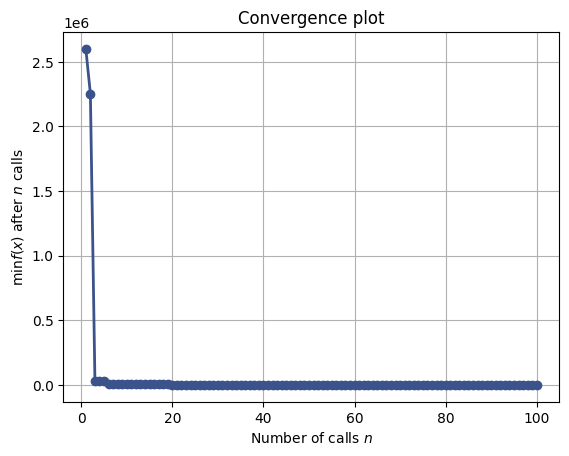

In [26]:
# Selon dernière valeur de la fonction coût
lhs = Lhs(lhs_type=lhs_type, criterion=criterion)
lhs_samples = lhs.generate(n_samples=bayes_best_score['n_samples'], dimensions=dimensions, random_state=random_seed)

result = gp_minimize(
    func=cost_function_bayesian,
    dimensions=dimensions,
    n_calls=100,
    acq_func=bayes_best_score['acq_fun'],
    x0=lhs_samples,
    random_state=random_seed
)
plot_convergence(result)
plt.show()

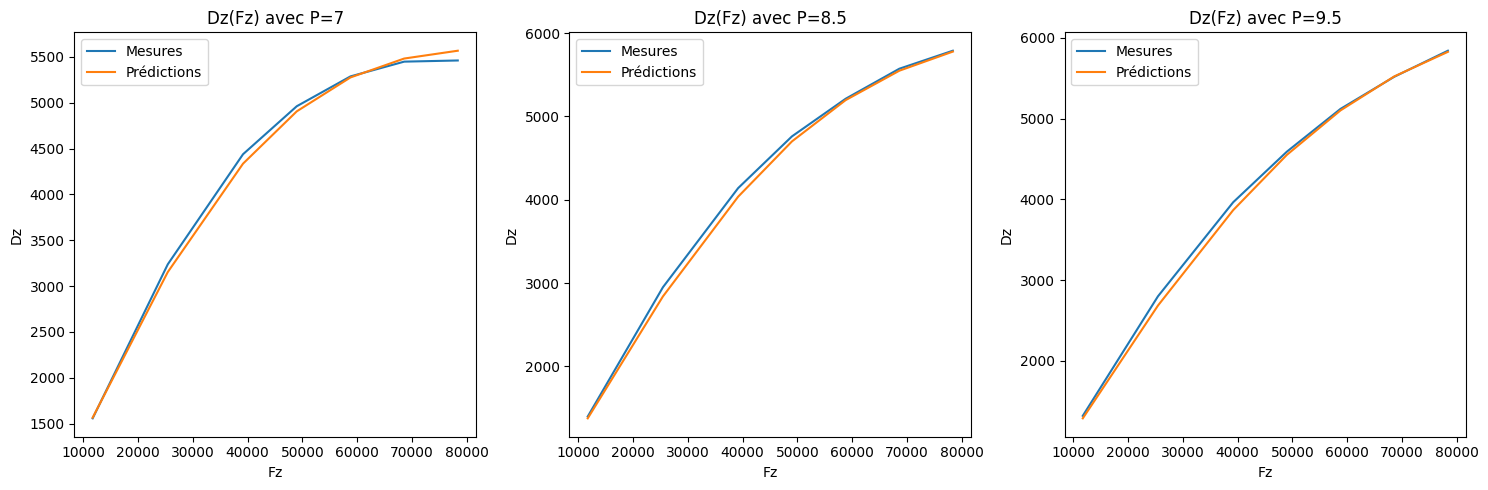

In [27]:
# Affichage de la superposition mesures/prédictions avec les nouvelles valeurs optimisées des paramètres

fig, axes = plt.subplots(1, 3, figsize=(15, 5)) # 1 ligne avec 3 plots

pred_7_last = [model(bayes_best_score["a1"], bayes_best_score["a2"], bayes_best_score["a3"], bayes_best_score["a4"], bayes_best_score["a5"], P[:7][i], Fz[:7][i]) for i in range(len(Fz[:7]))]
axes[0].plot(Fz[:7], Dz[:7], label="Mesures")
axes[0].plot(Fz[:7], pred_7_last, label="Prédictions")
axes[0].set_xlabel('Fz')
axes[0].set_ylabel('Dz')
axes[0].legend()
axes[0].set_title("Dz(Fz) avec P=7")

pred_8_5_last = [model(bayes_best_score["a1"], bayes_best_score["a2"], bayes_best_score["a3"], bayes_best_score["a4"], bayes_best_score["a5"], P[7:14][i], Fz[7:14][i]) for i in range(len(Fz[7:14]))]
axes[1].plot(Fz[7:14], Dz[7:14], label="Mesures")
axes[1].plot(Fz[7:14], pred_8_5_last, label="Prédictions")
axes[1].set_xlabel('Fz')
axes[1].set_ylabel('Dz')
axes[1].legend()
axes[1].set_title("Dz(Fz) avec P=8.5")

pred_9_5_last = [model(bayes_best_score["a1"], bayes_best_score["a2"], bayes_best_score["a3"], bayes_best_score["a4"], bayes_best_score["a5"], P[14:][i], Fz[14:][i]) for i in range(len(Fz[14:]))]
axes[2].plot(Fz[14:], Dz[14:], label="Mesures")
axes[2].plot(Fz[14:], pred_9_5_last, label="Prédictions")
axes[2].set_xlabel('Fz')
axes[2].set_ylabel('Dz')
axes[2].legend()
axes[2].set_title("Dz(Fz) avec P=9.5")

plt.tight_layout()
plt.show()

<div style="color: blue; font-weight: bold; font-size: 18px;">
    Comparaison avec la méthode de l'aire de la fonction coût
</div>

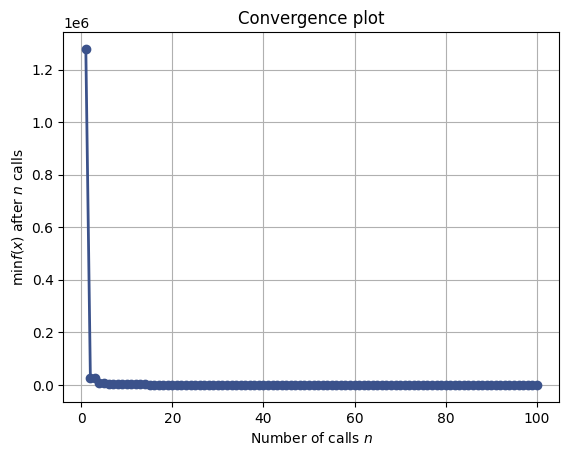

In [28]:
# Selon l'aire de la fonction coût
lhs = Lhs(lhs_type=lhs_type, criterion=criterion)
lhs_samples = lhs.generate(n_samples=bayes_area['n_samples'], dimensions=dimensions, random_state=random_seed)
y_init = np.array([cost_function_bayesian(sample) for sample in lhs_samples])
result = gp_minimize(
    func=cost_function_bayesian,
    dimensions=dimensions,
    n_calls=100,
    acq_func=bayes_area['acq_fun'],
    x0=lhs_samples,
    random_state=random_seed
)
plot_convergence(result)
plt.show()

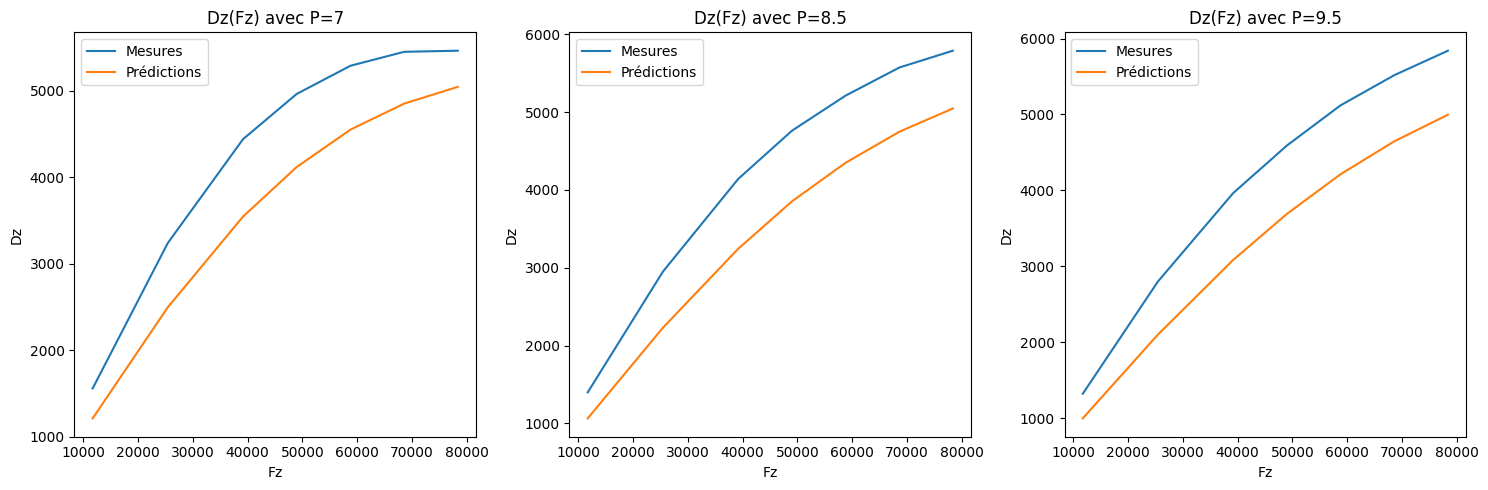

In [29]:
# Affichage de la superposition mesures/prédictions avec les nouvelles valeurs optimisées des paramètres

fig, axes = plt.subplots(1, 3, figsize=(15, 5)) # 1 ligne avec 3 plots

pred_7_area = [model(bayes_area["a1"], bayes_area["a2"], bayes_area["a3"], bayes_area["a4"], bayes_area["a5"], P[:7][i], Fz[:7][i]) for i in range(len(Fz[:7]))]
axes[0].plot(Fz[:7], Dz[:7], label="Mesures")
axes[0].plot(Fz[:7], pred_7_area, label="Prédictions")
axes[0].set_xlabel('Fz')
axes[0].set_ylabel('Dz')
axes[0].legend()
axes[0].set_title("Dz(Fz) avec P=7")

pred_8_5_area = [model(bayes_area["a1"], bayes_area["a2"], bayes_area["a3"], bayes_area["a4"], bayes_area["a5"], P[7:14][i], Fz[7:14][i]) for i in range(len(Fz[7:14]))]
axes[1].plot(Fz[7:14], Dz[7:14], label="Mesures")
axes[1].plot(Fz[7:14], pred_8_5_area, label="Prédictions")
axes[1].set_xlabel('Fz')
axes[1].set_ylabel('Dz')
axes[1].legend()
axes[1].set_title("Dz(Fz) avec P=8.5")

pred_9_5_area = [model(bayes_area["a1"], bayes_area["a2"], bayes_area["a3"], bayes_area["a4"], bayes_area["a5"], P[14:][i], Fz[14:][i]) for i in range(len(Fz[14:]))]
axes[2].plot(Fz[14:], Dz[14:], label="Mesures")
axes[2].plot(Fz[14:], pred_9_5_area, label="Prédictions")
axes[2].set_xlabel('Fz')
axes[2].set_ylabel('Dz')
axes[2].legend()
axes[2].set_title("Dz(Fz) avec P=9.5")

plt.tight_layout()
plt.show()

<div style="color: blue; font-weight: bold; font-size: 24px;">
    Conclusion sur les différentes estimations des paramètres
</div>

<div style="color: blue;">
    Nous allons pouvoir comparer les 6 méthodes que nous avons utilisés durant ce TP :
    <ol>
        <li>Méthodes des moindres carrés (leastsq)</li>
        <li>Descente de gradient (gradient)</li>
        <li>Fonction minize de scipy (minimize)</li>
        <li>Premier essai avec l'approche Bayésienne (bayes)</li>
        <li>Meilleure approche Bayésienne selon la dernière valeur de la fonction coût (bayes_score)</li>
        <li>Meilleure approche Bayésienne selon l'aire de la fonction coût (bayes_area)</li>
    </ol>
    Pour cela, nous allons le faire de 2 manières :
    <ol>
        <li>Graphiquement</li>
        <li>Numériquement en utilisant pour cela l'Erreur Quadratique Moyenne (Mean Squared Error, MSE)</li>
    </ol>
</div>

<div style="color: blue; font-weight: bold; font-size: 20px;">
    1. Partie graphique
</div>

<div style="color: blue; font-weight: bold; font-size: 18px;">
    Affichage des valeurs trouvées avec chaque méthode pour chaque paramètre
</div>

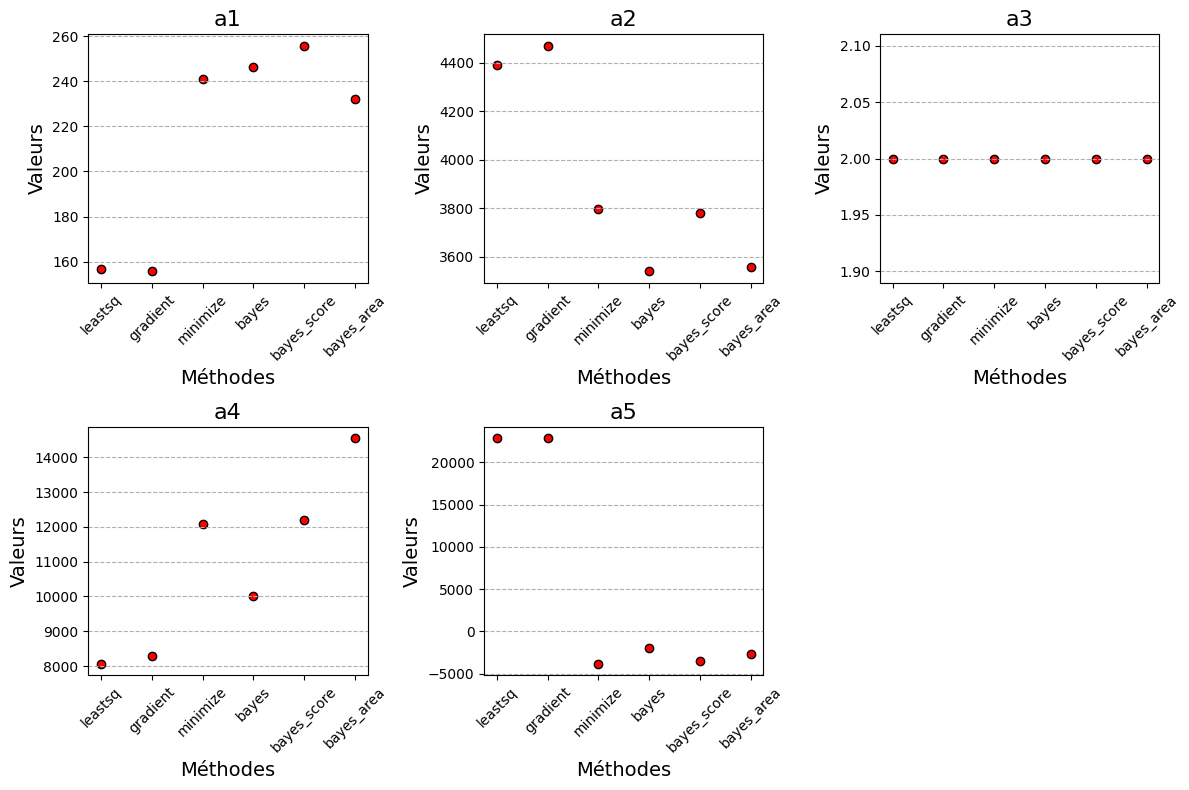

In [30]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8)) # 1 ligne avec 3 plots

# Données
methods = ['leastsq', 'gradient', 'minimize', 'bayes', 'bayes_score', 'bayes_area']
all_param = [
    [a1_opt_leastsq, a1_opt_gradient, a1_opt_minimize, a1_opt_bayes, bayes_best_score["a1"], bayes_area["a1"]],
    [a2_opt_leastsq, a2_opt_gradient, a2_opt_minimize, a2_opt_bayes, bayes_best_score["a2"], bayes_area["a2"]],
    [a3_opt_leastsq, a3_opt_gradient, a3_opt_minimize, a3_opt_bayes, bayes_best_score["a3"], bayes_area["a3"]],
    [a4_opt_leastsq, a4_opt_gradient, a4_opt_minimize, a4_opt_bayes, bayes_best_score["a4"], bayes_area["a4"]],
    [a5_opt_leastsq, a5_opt_gradient, a5_opt_minimize, a5_opt_bayes, bayes_best_score["a5"], bayes_area["a5"]]
]

cpt = 0
for i in range(2):
    for j in range(3):
        if i != 1 or j != 2:
            axes[i][j].scatter(methods, all_param[cpt], color="red", edgecolor='k')
            axes[i][j].set_xlabel('Méthodes', fontsize=14)
            axes[i][j].set_ylabel('Valeurs', fontsize=14)
            axes[i][j].set_title('a' + str(cpt + 1), fontsize=16)
            axes[i][j].grid(axis='y', linestyle='--')
            axes[i][j].tick_params(axis='x', labelrotation=45)
        cpt += 1


fig.delaxes(axes[1][2])

# Afficher le graphique
plt.tight_layout()
plt.show()

<div style="color: blue;">
    On peut remarquer ici que pour les paramètres $a1$ et $a2$, les valeurs trouvées sont relativement proches avec un écart respectivement de $100$ et $900$ pour $a1$ et $a2$.
    <br>
    A l'opposé, on observe une très forte dispersion pour les paramètres $a4$ et $a5$ avec un écart respectivement de $7 000$ et $30 000$.
</div>

<div style="color: blue; font-weight: bold; font-size: 18px;">
    Affichage de la superposition des courbes de mesures et celles calculées à partir des paramètres trouvés pour chaque palier de pression
</div>

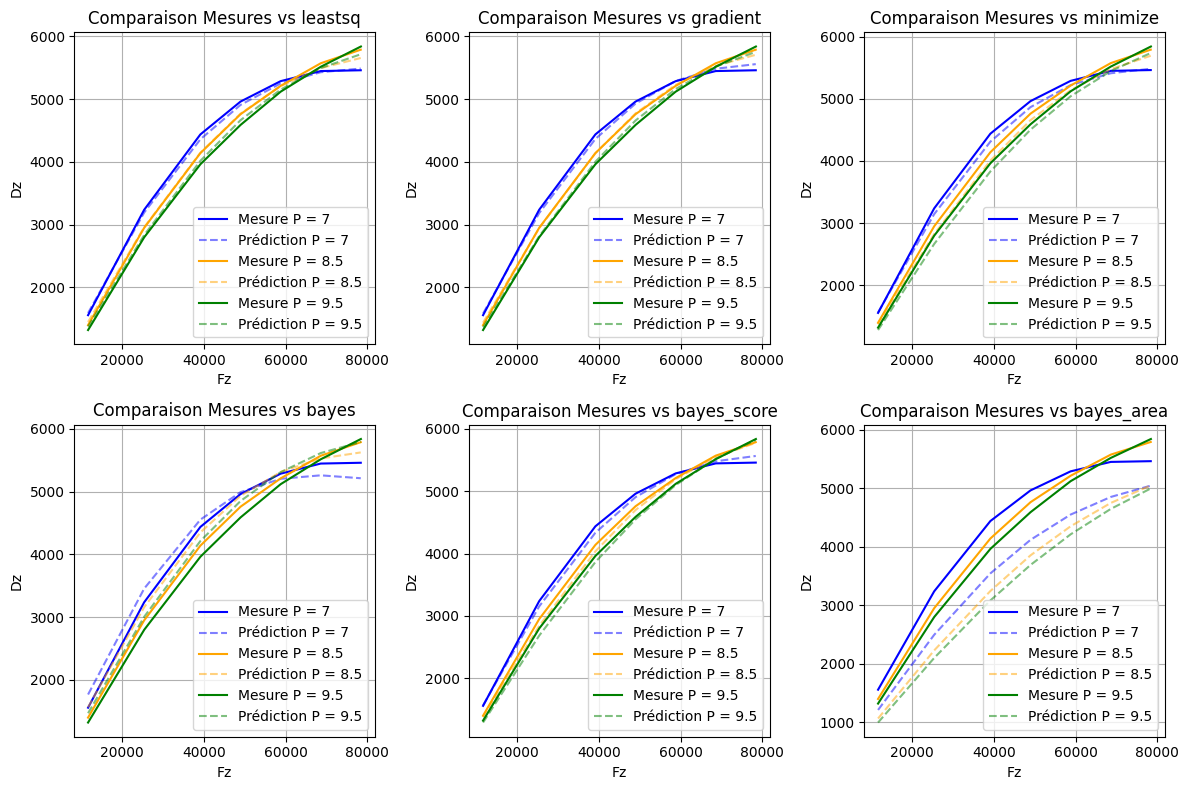

In [31]:
colors = ['blue','orange','green']
pression = [7, 8.5, 9.5]
title = ["leastsq", "gradient", "minimize", "bayes", "bayes_score", "bayes_area"]

all_model = [
    [pred_7_leastsq, pred_8_5_leastsq, pred_9_5_leastsq],
    [pred_7_gradient, pred_8_5_gradient, pred_9_5_gradient],
    [pred_7_minimize, pred_8_5_minimize, pred_9_5_minimize],
    [pred_7_bayes, pred_8_5_bayes, pred_9_5_bayes],
    [pred_7_last, pred_8_5_last, pred_9_5_last],
    [pred_7_area, pred_8_5_area, pred_9_5_area]
]

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

cpt = 0
for i in range(2):
    for j in range(3):
        for k in range(3):
            x, y = Fz[k*7:(k+1)*7], Dz[k*7:(k+1)*7]
            strLabel = "Mesure P = " + str(pression[k])
            axes[i][j].plot(x, y, label=strLabel, alpha=1, lw=1.5 , color = colors[k])
            
            strLabel = "Prédiction P = " + str(pression[k])
            axes[i][j].plot(x, all_model[cpt][k], label=strLabel, alpha=0.5, lw=1.5 , color = colors[k], linestyle='dashed')
            axes[i][j].set_title("Comparaison Mesures vs " + title[cpt])
            axes[i][j].grid()
            axes[i][j].set_xlabel('Fz')
            axes[i][j].set_ylabel('Dz')
            axes[i][j].legend()
        cpt += 1

# Afficher le graphique
plt.tight_layout()
plt.show()


<div style="color: blue;">
    On peut constater que les 3 premières méthodes ainsi que la méthode d'optimisation Bayésienne ayant le meilleur niveau de convergence approchent le mieux les courbes de mesures. La toute première méthode d'optimisation Bayésienne que l'on a essayé approche également bien les courbes mais reste moins efficace. Enfin, la méthode d'optimisation Bayésienne ayant une aire sous la courbe de la fonction coût minimale est de loin la pire méthode pour approcher les courbes de mesures.
</div>

<div style="color: blue; font-weight: bold; font-size: 20px;">
    2. Partie numérique
</div>

In [32]:
# P = 7
mse_opt_leastsq_7 = mean_squared_error(Dz[:7], pred_7_leastsq)
mse_opt_gradient_7 = mean_squared_error(Dz[:7], pred_7_gradient)
mse_opt_minimize_7 = mean_squared_error(Dz[:7], pred_7_minimize)
mse_opt_bayes_7 = mean_squared_error(Dz[:7], pred_7_bayes)
mse_opt_last_7 = mean_squared_error(Dz[:7], pred_7_last)
mse_opt_area_7 = mean_squared_error(Dz[:7], pred_7_area)

# P = 8.5
mse_opt_leastsq_8_5 = mean_squared_error(Dz[7:14], pred_8_5_leastsq)
mse_opt_gradient_8_5 = mean_squared_error(Dz[7:14], pred_8_5_gradient)
mse_opt_minimize_8_5 = mean_squared_error(Dz[7:14], pred_8_5_minimize)
mse_opt_bayes_8_5 = mean_squared_error(Dz[7:14], pred_8_5_bayes)
mse_opt_last_8_5 = mean_squared_error(Dz[7:14], pred_8_5_last)
mse_opt_area_8_5 = mean_squared_error(Dz[7:14], pred_8_5_area)

# P = 9.5
mse_opt_leastsq_9_5 = mean_squared_error(Dz[14:], pred_9_5_leastsq)
mse_opt_gradient_9_5 = mean_squared_error(Dz[14:], pred_9_5_gradient)
mse_opt_minimize_9_5 = mean_squared_error(Dz[14:], pred_9_5_minimize)
mse_opt_bayes_9_5 = mean_squared_error(Dz[14:], pred_9_5_bayes)
mse_opt_last_9_5 = mean_squared_error(Dz[14:], pred_9_5_last)
mse_opt_area_9_5 = mean_squared_error(Dz[14:], pred_9_5_area)

nb = 15
print(f"Affichage des valeurs de MSE")
print()
print(f"{'Etape':<{nb}}{'P = 7':>{nb}}{'P = 8.5':>{nb}}{'P = 9.5':>{nb}}")
print("-" * nb * 4)
print(f"{'Leastsq':<{nb}}" + f"{f'{mse_opt_leastsq_7:,.2f}'.replace(',', ' '):>{nb}}" + f"{f'{mse_opt_leastsq_8_5:,.2f}'.replace(',', ' '):>{nb}}" + f"{f'{mse_opt_leastsq_9_5:,.2f}'.replace(',', ' '):>{nb}}")
print(f"{'Gradient':<{nb}}" + f"{f'{mse_opt_gradient_7:,.2f}'.replace(',', ' '):>{nb}}" + f"{f'{mse_opt_gradient_8_5:,.2f}'.replace(',', ' '):>{nb}}" + f"{f'{mse_opt_gradient_9_5:,.2f}'.replace(',', ' '):>{nb}}")
print(f"{'Minimize':<{nb}}" + f"{f'{mse_opt_minimize_7:,.2f}'.replace(',', ' '):>{nb}}" + f"{f'{mse_opt_minimize_8_5:,.2f}'.replace(',', ' '):>{nb}}" + f"{f'{mse_opt_minimize_9_5:,.2f}'.replace(',', ' '):>{nb}}")
print(f"{'Bayes':<{nb}}" + f"{f'{mse_opt_bayes_7:,.2f}'.replace(',', ' '):>{nb}}" + f"{f'{mse_opt_bayes_8_5:,.2f}'.replace(',', ' '):>{nb}}" + f"{f'{mse_opt_bayes_9_5:,.2f}'.replace(',', ' '):>{nb}}")
print(f"{'Last':<{nb}}" + f"{f'{mse_opt_last_7:,.2f}'.replace(',', ' '):>{nb}}" + f"{f'{mse_opt_last_8_5:,.2f}'.replace(',', ' '):>{nb}}" + f"{f'{mse_opt_last_9_5:,.2f}'.replace(',', ' '):>{nb}}")
print(f"{'Area':<{nb}}" + f"{f'{mse_opt_area_7:,.2f}'.replace(',', ' '):>{nb}}" + f"{f'{mse_opt_area_8_5:,.2f}'.replace(',', ' '):>{nb}}" + f"{f'{mse_opt_area_9_5:,.2f}'.replace(',', ' '):>{nb}}")


Affichage des valeurs de MSE

Etape                    P = 7        P = 8.5        P = 9.5
------------------------------------------------------------
Leastsq               2 059.38       3 750.67       4 235.06
Gradient              2 950.78       1 480.16       2 525.81
Minimize              5 848.82       9 976.47       9 424.52
Bayes                29 800.94      26 321.07      35 061.44
Last                  4 780.41       3 971.50       3 672.38
Area                466 073.30     605 046.35     639 392.51


<div style="color: blue;">
    Ce que l'on avait vu graphiquement est confirmé ici.
    <br>
    Les 4 méthodes suivantes sont celles qui sont les plus efficaces : méthode des moindres carrés, méthode de la descente de gradient, méthode quasi-Newton et méthode d'optimisation Bayésienne ayant le meilleur niveau de convergence.
    <br>
    La toute première méthode d'optimisation Bayésienne reste efficace mais moins que les méthodes précédentes.
    <br>
    Et la méthode d'optimisation Bayésienne ayant l'aire sous la courbe de la fonction coût minimale est de loin très médiocre.
</div>

<div style="color: blue; font-weight: bold; font-size: 24px;">
    Voici le classement des méthodes selon les valeurs de la MSE :
</div>

<div style="color: blue; font-size: 20px;">
    <ol>
        <li>Descente de gradient</li>
        <li>Méthode des moindres carrés</li>
        <li>Approche Bayésienne ayant le meilleur niveau de convergence</li>
        <li>Méthode quasi-Newton avec la fonction minimze de scipy</li>
        <li>Premier essai avec l'approche Bayésienne</li>
        <li>Approcha Bayésienne ayant la plus petite aire sous la courbe pour la fonction coût</li>
    </ol
</div>